In [2]:
import pandas as pd
from copy import deepcopy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import warnings
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1500)
from sklearn.linear_model import LogisticRegression
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

# Load Data

In [4]:
loan = pd.read_csv("C:/Users/navya/Desktop/AML/Project1/SBA_loans_project_1.zip",index_col=0)
loan1=loan.head(400000)

In [5]:
print("Data shape:", loan1.shape)

Data shape: (400000, 20)


In [6]:
desc_df = describe_more(loan1)
desc_df

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,City,23598,object,1,30,"{'LOS ANGELES': 5129, 'HOUSTON': 4616, 'NEW YO..."
1,State,51,object,2,3,"{'CA': 57850, 'TX': 31312, 'NY': 25678, 'FL': ..."
2,Zip,27286,int64,1,5,"{10001: 400, 90015: 398, 93401: 341, 90010: 33..."
3,Bank,5000,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 38661, 'WELLS F..."
4,BankState,54,object,2,3,"{'CA': 52413, 'NC': 35426, 'IL': 29417, 'OH': ..."
5,NAICS,1278,int64,1,6,"{0: 89952, 722110: 12352, 722211: 8744, 811111..."
6,Term,378,int64,1,3,"{84: 102256, 60: 40194, 240: 38102, 120: 34388..."
7,NoEmp,453,int64,1,4,"{1: 69031, 2: 61496, 3: 40106, 4: 32789, 5: 26..."
8,NewExist,3,float64,3,3,"{1.0: 286961, 2.0: 112508, 0.0: 467}"
9,CreateJob,192,int64,1,4,"{0: 279840, 1: 28051, 2: 25942, 3: 12895, 4: 9..."


In [7]:
target=loan1['MIS_Status']
target_var='MIS_Status'
drop_from_data=['RevLineCr','Zip','NoEmp','City','CreateJob','RetainedJob']
loan1=loan1.drop(columns=drop_from_data, axis=1)

In [8]:
# Create a list to store the columns to train with 
data_cols=loan1.drop(columns=['MIS_Status']).columns
data_cols

Index(['State', 'Bank', 'BankState', 'NAICS', 'Term', 'NewExist',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'BalanceGross', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [9]:
# Explore Data, remove all the null values from target variable 
loan1=loan1.dropna(subset=['MIS_Status'])
loan1.groupby(by='MIS_Status')['MIS_Status'].count()

MIS_Status
CHGOFF     70381
P I F     328744
Name: MIS_Status, dtype: int64

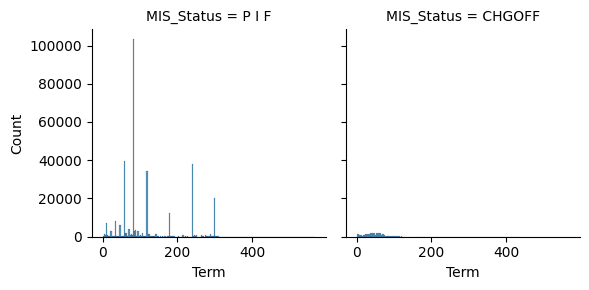

In [10]:
#From the above the data is highly imbalanced
#plot the distribution 
g = sns.FacetGrid(loan1, col="MIS_Status")
g.map(sns.histplot, 'Term')

# Dataset preparation and clean-up
Modify and clean-up the dataset as following:

    Replace encode Na/Null values
    Convert the strings styled as '$XXXX.XX' to float values. Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
    Convert MIS_Status to 0/1. Make value "CHGOFF" as 1

Any additional clean-up as you find fit.

In [11]:
# Filled the missing values
fill_na={}
for col in loan1.drop(columns=['MIS_Status']).columns:
    if pd.api.types.is_numeric_dtype(loan1[col].dtype):
        fill_na[col]=0
    else:
        fill_na[col]='Missing'
loan1.fillna(value=fill_na,inplace=True)

In [12]:
# removed '$'
col_remove_dollar = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
for col in col_remove_dollar:
    loan1[col] = loan1[col].str.replace('$','',regex=True).replace(',','',regex=True)
    loan1[col] = loan1[col].astype(float)

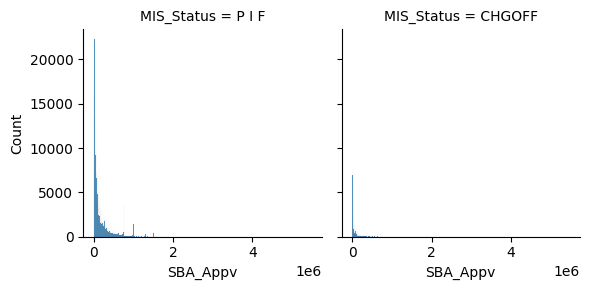

In [13]:
# Plot
g1 = sns.FacetGrid(loan1, col="MIS_Status")
g1.map(sns.histplot, 'SBA_Appv')

In [14]:
#Convert MIS_Status
loan1['MIS_Status'] = [1 if app == 'CHGOFF' else 0 for app in loan1.MIS_Status.values]

In [15]:
# We also observe that there are many missing values in the LowDoc Column and their proportion is very small compared to 
# total records. Hence deleting those records and then replacing N and Y  0 and 1 
cat_enc_columns=[]
loan1.groupby(by=["LowDoc"])["LowDoc"].count()
# Since there are misstyped values , Delete it
values=['0','A','C','Missing','R','S','nan']
loan1 = loan1[loan1.LowDoc.isin(values) == False]
loan1['LowDoc']=loan1['LowDoc'].astype('category',copy=True)

# Categorical and numerical variables encoding
Encode categorical variables using either one of the techniques below

In [16]:
# Before encoding , performed Feature Engineering
loan1['NewExist']=loan1['NewExist'].astype('category',copy=True)
loan1 = loan1.loc[loan1['NewExist'] != 0]

In [17]:
loan1['UrbanRural']=loan1['UrbanRural'].apply(lambda x: 'Urban' if x == 1 else  'Rural' if x==2 else 'Undefined')
loan1['UrbanRural']=loan1['UrbanRural'].astype('category',copy=True)

In [18]:
loan1['FranchiseCode']=loan1['FranchiseCode'].apply(lambda x: 'N' if x in [0,1] else 'Y')
loan1['FranchiseCode'] = loan1['FranchiseCode'].astype('category',copy=False)

In [19]:
# Adding New Features
# Get the frequency of each industry using frequency encoding 
loan1['NAICS'] = loan1['NAICS']%100
loan1['NAICS'] = loan1['NAICS'].astype('category',copy=False)

# calculate the net loan 
loan1['Net_Loan']=loan1['DisbursementGross']-loan1['BalanceGross']

# calculate the risk percentage that SBA bears on each loan provided
loan1['SBA_Payable']=(loan1['SBA_Appv']/loan1['GrAppv'])

# Dimension Reduction
loan1['Term']=loan1['Term']/12

In [20]:
''' Split the data to train validation and test'''
X=loan1
Y=loan1['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X,Y,
    test_size=0.2, shuffle = True, random_state = 42,stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 42,stratify=y_train)

In [21]:
ohe_columns=[]
for col in X_train.drop(columns=['MIS_Status']).columns:
    if X_train[col].dtype == 'category':
        if X_train[col].nunique() < 10:
            one_hot_enc = pd.get_dummies(X_train[col], prefix=col)
            X_train = pd.concat([X_train, one_hot_enc], axis=1)
            one_hot_enc_val=pd.get_dummies(X_val[col], prefix=col)
            X_val = pd.concat([X_val, one_hot_enc_val], axis=1)
            one_hot_enc_tst=pd.get_dummies(X_test[col], prefix=col)
            X_test = pd.concat([X_test, one_hot_enc_tst], axis=1)
            ohe_columns.extend(one_hot_enc)

In [22]:
cols_numerical_orig=[]
woe_te_cols=[]
for col in X_train.drop(columns=['MIS_Status','LowDoc','UrbanRural','FranchiseCode','NewExist']+ohe_columns).columns:
    if pd.api.types.is_numeric_dtype(X_train[col].dtype):
        print('Column to process:', col)
        cols_numerical_orig.append(col)
    else:
        woe_te_cols.append(col)

Column to process: Term
Column to process: DisbursementGross
Column to process: BalanceGross
Column to process: GrAppv
Column to process: SBA_Appv
Column to process: Net_Loan
Column to process: SBA_Payable


In [23]:
#WOE encoding
woe_encoder = ce.WOEEncoder(cols=woe_te_cols)
woe_encoder.fit(X_train[woe_te_cols],X_train['MIS_Status'])
woe_enc_train = woe_encoder.transform(X_train[woe_te_cols])
woe_enc_test = woe_encoder.transform(X_test[woe_te_cols])
woe_enc_valid = woe_encoder.transform(X_val[woe_te_cols])
woe_columns = []
for col in woe_te_cols:
    X_train[col+"_woe"] = woe_enc_train[col]
    X_test[col+"_woe"] = woe_enc_test[col]
    X_val[col+"_woe"] = woe_enc_valid[col]
    woe_columns.append(col+"_woe")
X_val.head(5)

,State,Bank,BankState,NAICS,Term,NewExist,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Net_Loan,SBA_Payable,NewExist_0.0,NewExist_1.0,NewExist_2.0,FranchiseCode_N,FranchiseCode_Y,UrbanRural_Rural,UrbanRural_Undefined,UrbanRural_Urban,LowDoc_N,LowDoc_Y,State_woe,Bank_woe,BankState_woe,NAICS_woe
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56183,MD,BRANCH BK. & TR CO,NC,10,5.0,2.0,N,Rural,N,142000.0,0.0,142000.0,71000.0,0,142000.0,0.50,0,0,1,1,0,1,0,0,1,0,0.137428,-0.557008,0.671929,0.013532
322104,AZ,BANK OF AMERICA NATL ASSOC,OR,0,3.0,1.0,N,Undefined,N,6500.0,0.0,6500.0,3250.0,0,6500.0,0.50,0,1,0,1,0,0,1,0,1,0,0.230968,0.585415,0.024071,-0.833275
34387,CA,CERTIFIED DEVEL CORP OF TULARE,CA,14,20.0,1.0,N,Urban,N,587000.0,0.0,587000.0,587000.0,0,587000.0,1.00,0,1,0,1,0,0,0,1,1,0,0.066509,-2.367771,0.278564,-0.147757
307605,LA,GULF COAST BUS. & INDUST DEVEL,LA,15,5.0,1.0,N,Urban,Y,115000.0,0.0,115000.0,86250.0,0,115000.0,0.75,0,1,0,1,0,0,0,1,0,1,0.097454,0.000000,-0.508564,0.730453
165510,CA,WASHINGTON FEDERAL NATL ASSOC,OR,0,7.0,1.0,N,Undefined,N,150000.0,0.0,150000.0,135000.0,1,150000.0,0.90,0,1,0,1,0,0,1,0,1,0,0.066509,-0.871661,0.024071,-0.833275


In [24]:
#target encoding
TEenc = TargetEncoder()
encoder_te = TEenc.fit(X_train[woe_te_cols],y_train )
train_enc_te= encoder_te.transform(X_train[woe_te_cols])
test_enc_te=encoder_te.transform(X_test[woe_te_cols])
val_enc_te=encoder_te.transform(X_val[woe_te_cols])
for col in woe_te_cols:
    X_train[col+"_te"] = train_enc_te[col]
    X_test[col+"_te"] = test_enc_te[col]
    X_val[col+"_te"] = val_enc_te[col]

In [25]:
# Scale the data using standard scalar
for col in X_train[cols_numerical_orig]:
    scaler = StandardScaler()
    scaler.fit(X_train[[col]])
    X_train[col+"_sc"] = scaler.transform(X_train[[col]])
    X_val[col+"_sc"] = scaler.transform(X_val[[col]])
    X_test[col+"_sc"] = scaler.transform(X_test[[col]])

In [26]:
X_val.head(2)

,State,Bank,BankState,NAICS,Term,NewExist,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Net_Loan,SBA_Payable,NewExist_0.0,NewExist_1.0,NewExist_2.0,FranchiseCode_N,FranchiseCode_Y,UrbanRural_Rural,UrbanRural_Undefined,UrbanRural_Urban,LowDoc_N,LowDoc_Y,State_woe,Bank_woe,BankState_woe,NAICS_woe,State_te,Bank_te,BankState_te,NAICS_te,Term_sc,DisbursementGross_sc,BalanceGross_sc,GrAppv_sc,SBA_Appv_sc,Net_Loan_sc,SBA_Payable_sc
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56183,MD,BRANCH BK. & TR CO,NC,10,5.0,2.0,N,Rural,N,142000.0,0.0,142000.0,71000.0,0,142000.0,0.5,0,0,1,1,0,1,0,0,1,0,0.137428,-0.557008,0.671929,0.013532,0.196562,0.108616,0.294752,0.177878,-0.645355,-0.207652,-0.00225,-0.180609,-0.345560,-0.207642,-1.20107
322104,AZ,BANK OF AMERICA NATL ASSOC,OR,0,3.0,1.0,N,Undefined,N,6500.0,0.0,6500.0,3250.0,0,6500.0,0.5,0,1,0,1,0,0,1,0,1,0,0.230968,0.585415,0.024071,-0.833275,0.211813,0.277092,0.179216,0.084887,-0.949544,-0.681352,-0.00225,-0.660943,-0.642532,-0.681351,-1.20107


In [27]:
# Apply oversampling on the target variable as the classes are highly imbalanced[only on training data]
Sampler=RandomOverSampler()
X_train_over, y_train_over = Sampler.fit_resample(X_train, y_train)
X_test_over=X_test.copy()
y_test_over=y_test.copy()
X_val_over=X_val.copy()
y_val_over=y_val.copy()

In [28]:
cols_numerical_usc_woe=['State_woe','Net_Loan','GrAppv','SBA_Appv','SBA_Payable','NAICS_woe','BankState_woe','Bank_woe','Term']
cols_numerical_usc_te=['State_te','Net_Loan','GrAppv','SBA_Payable','SBA_Appv','NAICS_te','BankState_te','Bank_te','Term']
cols_numerical_sc_woe=['State_woe','Net_Loan_sc','GrAppv_sc','SBA_Payable_sc','SBA_Appv_sc','NAICS_woe','BankState_woe','Bank_woe','Term_sc']
cols_numerical_sc_te=['State_te','Net_Loan_sc','GrAppv_sc','SBA_Payable_sc','SBA_Appv_sc','NAICS_te','BankState_te','Bank_te','Term_sc']


In [29]:
X_train.head(5)

,State,Bank,BankState,NAICS,Term,NewExist,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Net_Loan,SBA_Payable,NewExist_0.0,NewExist_1.0,NewExist_2.0,FranchiseCode_N,FranchiseCode_Y,UrbanRural_Rural,UrbanRural_Undefined,UrbanRural_Urban,LowDoc_N,LowDoc_Y,State_woe,Bank_woe,BankState_woe,NAICS_woe,State_te,Bank_te,BankState_te,NAICS_te,Term_sc,DisbursementGross_sc,BalanceGross_sc,GrAppv_sc,SBA_Appv_sc,Net_Loan_sc,SBA_Payable_sc
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141512,UT,MOUNTAIN AMERICA FCU,UT,90,7.000000,2.0,N,Rural,N,39000.0,0.0,25000.0,12500.0,0,39000.0,0.50,0,0,1,1,0,1,0,0,1,0,0.036114,1.013340,0.005339,0.480825,0.181087,0.369838,0.176564,0.256617,-0.341167,-0.567734,-0.00225,-0.595363,-0.601986,-0.567731,-1.201070
323006,OR,WELLS FARGO BANK NATL ASSOC,SD,10,22.083333,1.0,N,Undefined,N,413778.0,0.0,460000.0,322000.0,0,413778.0,0.70,0,1,0,1,0,0,1,0,1,0,-0.228042,-0.237813,0.047926,0.013532,0.145009,0.144006,0.182927,0.177878,1.952924,0.742467,-0.00225,0.946669,0.754661,0.742495,-0.050968
228906,MD,"CITIBANK, N.A.",SD,90,25.000000,1.0,N,Rural,N,4140000.0,0.0,4140000.0,3105000.0,0,4140000.0,0.75,0,1,0,1,0,1,0,0,1,0,0.137428,0.022914,0.047926,0.480825,0.196562,0.178937,0.182927,0.256617,2.396533,13.769107,-0.00225,13.991902,12.953530,13.769384,0.236558
357657,MN,WELLS FARGO BANK NATL ASSOC,SD,30,4.166667,2.0,N,Urban,N,37078.0,0.0,20000.0,10000.0,1,37078.0,0.50,0,0,1,1,0,0,0,1,1,0,-0.448992,-0.237813,0.047926,0.029042,0.119797,0.144006,0.182927,0.180114,-0.772101,-0.574453,-0.00225,-0.613087,-0.612945,-0.574450,-1.201070
273524,IA,COMMUNITY BANK,IA,10,10.000000,1.0,N,Rural,N,115100.0,0.0,115100.0,57550.0,0,115100.0,0.50,0,1,0,1,0,1,0,0,1,0,-0.420622,-0.379996,-0.539565,0.013532,0.122701,0.125000,0.110377,0.177878,0.115117,-0.301693,-0.00225,-0.275967,-0.404516,-0.301685,-1.201070


# Model 1: Logistic Regressions

In [30]:
# run Logistic regression on WOE encoded unscaled data 
X_tr = X_train[cols_numerical_usc_woe+ohe_columns]
Y_tr = y_train
X_tst = X_test[cols_numerical_usc_woe+ohe_columns]
Y_tst = y_test
X_v = X_val[cols_numerical_usc_woe+ohe_columns]
Y_v = y_val

In [31]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []
for c in c_range:
    logistic_l1 = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    logistic_l2 = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    logistic_l1.fit(X_tr, Y_tr)
    logistic_l2.fit(X_tr, Y_tr)
    train_score_l1.append(logistic_l1.score(X_tr, Y_tr))
    train_score_l2.append(logistic_l2.score(X_tr, Y_tr))
    test_score_l1.append(logistic_l1.score(X_tst, Y_tst))
    test_score_l2.append(logistic_l2.score(X_tst, Y_tst))

In [32]:
# F-1 Score
from sklearn.metrics import f1_score
y_train_pred=logistic_l1.predict(X_tr)
f1_train=f1_score(y_train_pred,Y_tr,average='macro')
y_v_pred=logistic_l1.predict(X_v)
f1_val=f1_score(y_v_pred,Y_v,average='macro')
print(f1_train,f1_val)

0.6926464690611955 0.6906975081049838


In [33]:
# check the Features
features = list(X_tr.columns)
coef = logistic_l1.coef_
for feature, weight in zip(features, coef[0]):
    print(feature, weight)
#from the feature importance obtained for the model: SBA_Payable, Term, Bankstate ,UrbanRural seems 
#to be highly important terms.

State_woe 0.6030971476393311
Net_Loan -6.694996953285471e-07
GrAppv 3.426427807532357e-06
SBA_Appv -2.368435718059653e-06
SBA_Payable 1.8569616681971663
NAICS_woe -0.026422430256517703
BankState_woe 0.22408534635006955
Bank_woe 0.8399185573514816
Term -0.3193824179451402
NewExist_0.0 0.0
NewExist_1.0 -0.02885623095353139
NewExist_2.0 0.1858648120939548
FranchiseCode_N -0.11759248367208074
FranchiseCode_Y 0.15319646536523374
UrbanRural_Rural -0.2878229331760934
UrbanRural_Undefined -1.2245151561434142
UrbanRural_Urban -0.27675551687925354
LowDoc_N -0.02149952038004063
LowDoc_Y -0.7110535574773595


# Model 2 :LR

In [34]:
# run Logistic regression on woe encoded oversampled data
X_tr_over = X_train_over[cols_numerical_usc_woe+ohe_columns]
Y_tr_over = y_train_over
X_tst_over = X_test_over[cols_numerical_usc_woe+ohe_columns]
Y_tst_over = y_test_over
X_v_over = X_val_over[cols_numerical_usc_woe+ohe_columns]
Y_v_over = y_val_over
for c in c_range:
    logistic_ol1 = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    logistic_ol2 = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    logistic_ol1.fit(X_tr_over, Y_tr_over)
    logistic_ol2.fit(X_tr_over, Y_tr_over)
# F-1 Score
y_train_over_pred=logistic_ol1.predict(X_tr_over)
f1_train_over=f1_score(y_train_over_pred,Y_tr_over,average='macro')
y_v_over_pred=logistic_ol1.predict(X_v_over)
f1_v_over=f1_score(y_v_over_pred,Y_v_over,average='macro')
print(f1_train_over,f1_v_over)

0.7702855560865389 0.665241887798715


In [35]:
# run Logistic regression on target encoded oversampled data 
X_tr_te = X_train_over[cols_numerical_usc_te+ohe_columns]
Y_tr_te = y_train_over
X_tst_te = X_test_over[cols_numerical_usc_te+ohe_columns]
Y_tst_te = y_test_over
X_v_te = X_val_over[cols_numerical_usc_te+ohe_columns]
Y_v_te = y_val_over
for c in c_range:
    logistic_te_l1 = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    logistic_te_l2 = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    logistic_te_l1.fit(X_tr_te, Y_tr_te)
    logistic_te_l2.fit(X_tr_te, Y_tr_te)

# F-1 Score
y_train_te_pred=logistic_te_l1.predict(X_tr_te)
f1_train_te=f1_score(y_train_te_pred,Y_tr_te,average='macro')
y_v_te_pred=logistic_te_l1.predict(X_v_te)
f1_val_te=f1_score(y_v_te_pred,Y_v_te,average='macro')
print(f1_train_te,f1_val_te)

0.7724886932909936 0.6720057902846832


# Model 3

In [36]:
# run Logistic regression over Scaled oversampled data with woe encoding
X_tr_sc = X_train_over[cols_numerical_sc_woe+ohe_columns]
Y_tr_sc= y_train_over
X_tst_sc = X_test_over[cols_numerical_sc_woe+ohe_columns]
Y_tst_sc = y_test_over
X_v_sc = X_val_over[cols_numerical_sc_woe+ohe_columns]
Y_v_sc = y_val_over

In [37]:
for c in c_range:
    logistic_ol1_sc = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    logistic_ol2_sc = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    logistic_ol1_sc.fit(X_tr_sc, Y_tr_sc)
    logistic_ol2_sc.fit(X_tr_sc, Y_tr_sc)
y_train_over_pred=logistic_ol1_sc.predict(X_tr_sc)
f1_train_over=f1_score(y_train_over_pred,Y_tr_sc,average='macro')
y_v_over_pred=logistic_ol1_sc.predict(X_v_sc)
f1_tst_sc=f1_score(y_v_over_pred,Y_v_sc,average='macro')
print(f1_train_over,f1_tst_sc)

0.7703131414938278 0.6652215010568403


In [38]:
X_tr.head(10)

,State_woe,Net_Loan,GrAppv,SBA_Appv,SBA_Payable,NAICS_woe,BankState_woe,Bank_woe,Term,NewExist_0.0,NewExist_1.0,NewExist_2.0,FranchiseCode_N,FranchiseCode_Y,UrbanRural_Rural,UrbanRural_Undefined,UrbanRural_Urban,LowDoc_N,LowDoc_Y
index,,,,,,,,,,,,,,,,,,,
141512,0.036114,39000.0,25000.0,12500.0,0.50,0.480825,0.005339,1.013340,7.000000,0,0,1,1,0,1,0,0,1,0
323006,-0.228042,413778.0,460000.0,322000.0,0.70,0.013532,0.047926,-0.237813,22.083333,0,1,0,1,0,0,1,0,1,0
228906,0.137428,4140000.0,4140000.0,3105000.0,0.75,0.480825,0.047926,0.022914,25.000000,0,1,0,1,0,1,0,0,1,0
357657,-0.448992,37078.0,20000.0,10000.0,0.50,0.029042,0.047926,-0.237813,4.166667,0,0,1,1,0,0,0,1,1,0
273524,-0.420622,115100.0,115100.0,57550.0,0.50,0.013532,-0.539565,-0.379996,10.000000,0,1,0,1,0,1,0,0,1,0
383614,0.308922,50000.0,50000.0,25000.0,0.50,0.687488,1.084988,1.194814,5.333333,0,1,0,1,0,0,0,1,1,0
184322,-0.381329,479000.0,479000.0,479000.0,1.00,-0.833275,-0.438767,-4.316534,20.000000,0,0,1,1,0,0,1,0,1,0
250425,0.258017,93000.0,93000.0,79050.0,0.85,0.265151,-0.499142,-0.600447,10.000000,0,0,1,1,0,0,0,1,0,1
164423,0.066509,38766.0,20000.0,10000.0,0.50,0.013532,-0.106590,0.029416,5.250000,0,0,1,1,0,0,0,1,1,0


In [ ]:
# Scaling did not improve the scores much.

In [ ]:
#Oversampling improved only the training data score but not on validation data. It could be possible that the training oversampled
# data was overfit by the regression model.Hence the original data with WOE encoding has the best score among the above models

In [39]:
fpr, tpr, thresholds = roc_curve(Y_v, logistic_l1.predict_proba(X_v)[:,1])

# Calculate index for the best probability threshold
best_f1 = 0
best_f1_id = 0
for id,threshold in enumerate(thresholds):
    f1 = f1_score(logistic_l1.predict_proba(X_v)[:,1] >= threshold, Y_v,average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id

print("Best f1:", best_f1)
best_threshold = thresholds[best_f1_id]
print("Threshold for best F1:", best_threshold)

Best f1: 0.7620849765691284
Threshold for best F1: 0.33966631146453247


In [ ]:
#the best threshold came out to be around 0.34. Since the original dataset was extremely voluminous, I trained the dataset only 

# GLM Models

In [40]:
import h2o
try:
    h2o.init()
    h2o.cluster().shutdown()
except:
    pass

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.6+9-LTS-190, mixed mode, sharing)
  Starting server from C:\Users\navya\ml-spring-23\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\navya\AppData\Local\Temp\tmpdytry60i
  JVM stdout: C:\Users\navya\AppData\Local\Temp\tmpdytry60i\h2o_navya_started_from_python.out
  JVM stderr: C:\Users\navya\AppData\Local\Temp\tmpdytry60i\h2o_navya_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_navya_wl7oit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.840 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


H2O session _sid_bf6d closed.


In [41]:
#Limit to 8 threads and 8GB memory
h2o.init(nthreads=8, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.6+9-LTS-190, mixed mode, sharing)
  Starting server from C:\Users\navya\ml-spring-23\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\navya\AppData\Local\Temp\tmpkxgzcxwq
  JVM stdout: C:\Users\navya\AppData\Local\Temp\tmpkxgzcxwq\h2o_navya_started_from_python.out
  JVM stderr: C:\Users\navya\AppData\Local\Temp\tmpkxgzcxwq\h2o_navya_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_navya_uw4zps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [42]:
from h2o.frame import H2OFrame
# Load your scikit-learn datasets
data=H2OFrame(loan1)
cat_columns = [ 'NewExist','LowDoc','FranchiseCode','UrbanRural']
encoded_columns=cat_columns
response = target_var
data[encoded_columns+[response]] = data[encoded_columns+[response]].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
data.head(3)

State,Bank,BankState,NAICS,Term,NewExist,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Net_Loan,SBA_Payable
MD,"BUSINESS FINANCE GROUP, INC.",VA,11,20,1,N,Urban,N,743000,0,743000,743000,0,743000,1
WI,JPMORGAN CHASE BANK NATL ASSOC,IL,10,20,1,N,Undefined,N,137000,0,137000,109737,0,137000,0.801
CA,UMPQUA BANK,OR,0,10,1,N,Undefined,N,280000,0,280000,210000,0,280000,0.75


In [44]:
train,test,valid = data.split_frame(ratios=[.6, .2], seed=123)

In [45]:
variables=train.columns
#tried performing WOEEncoding, but got a error which I suspect is due to unavailability of the packge in the latest version of 
#H2O. Hence continuing using one hot encoding and the transforms initially computed.

# Model 1 : GLM

In [46]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
#maintaining a solver = LBFGS and lambda as Lasso
model1 = H2OGeneralizedLinearEstimator(family='binomial',solver='L_BFGS',alpha=1)
model1.train(x=variables, y=response, training_frame=train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1680496558086_1


GLM Model: summary
    family    link    regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Lasso (lambda = 1.197E-4 )  5114                          102                            177                     py_4_sid_a3ac

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.09963763555896123
RMSE: 0.3156542975455288
LogLoss: 0.3425052296551137
AUC: 0.8565925165644142
AUCPR: 0.6221560109223487
Gini: 0.7131850331288283
Null degrees of freedom: 238059
Residual degrees of freedom: 237957
Null deviance: 221838.94179446757
Residual deviance: 163073.58994339273
AIC: 163279.58994339273

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3058386676255179
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      177573  18487  0.0943   (18487.0/196060.0)
1      14010   27990  0.3336   (14010.0/42000.0)
Total  191583  46477  0.1365   (32497.0/238060.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305839     0.632707  192
max f2                       0.216458     0.687377  240
max f0point5                 0.393887     0.644851  154
max accuracy                 0.365077     0.873818  166
max precision                0.647048     0.81451   63
max recall                   0.000373385  1         399
max specificity              0.966122     0.999929  0
max absolute_mcc             0.305839     0.5502    192
max min_per_class_accuracy   0.214509     0.79169   241
max mean_per_class_accuracy  0.253818     0.795217  220
max tns                      0.966122     196046    0
max fns                      0.966122     41997     0
max fps                      0.000373385  196060    399
max tps                      0.000373385  42000     399
max tnr                      0.966122     0.999929  0
max fnr                      0.966122     0.999929  0
max fpr                      0.000373385  1         399
max tpr                      0.000373385  1         399

Gains/Lift Table: Avg response rate: 17.64 %, avg score: 17.62 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100017                   0.760489           4.54686    4.54686            0.802184         0.817647     0.802184                    0.817647            0.0454762       0.0454762                  354.686   354.686            0.0430739
2        0.0200076                   0.695871           4.65203    4.59945            0.820739         0.725956     0.811463                    0.771792            0.0465476       0.0920238                  365.203   359.945            0.0874436
3        0.0300008                   0.651009           4.6436     4.61416            0.819252         0.672686     0.814058                    0.73878             0.0464048       0.138429                   364.36    361.416            0.131655
4        0.0400025                   0.614385           4.42069    4.56578            0.779924         0.632283     0.805523                    0.712153            0.0442143       0.182643                   342.069   35

In [47]:
f1_model1=model1.F1()
print("F1 score: ", f1_model1)
# for threshold 0.313 the F1 score is 0.635.

F1 score:  [[0.3058386676255179, 0.6327068051584027]]


# Model 2

In [48]:
# Changing the Solver to AUTO and performing a lasso regularization
model2 = H2OGeneralizedLinearEstimator(family='binomial',solver='AUTO',alpha=1)
model2.train(x=variables, y=response, training_frame=train)
f1_model2=model2.F1()
print("F1 score: ", f1_model2)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
F1 score:  [[0.30397046309715153, 0.6337815957542503]]


# Model 3

In [49]:
# Changing the Solver to AUTO and performing a lasso regularization
# Maintaining the Solver to AUTO and performing a Ridge regularization
model3 = H2OGeneralizedLinearEstimator(family='binomial',solver='AUTO',alpha=0)
model3.train(x=variables, y=response, training_frame=train,)
f1_model3=model3.F1()
print("F1 score: ", f1_model3)
#Since there are more than 5k active predictors AUTO is probably taking LFBGS

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
F1 score:  [[0.31174571491314995, 0.6415810528229839]]


# Model 4

In [50]:
# Maintaining the Solver to LFBGS and performing a Ridge regularization
model4 = H2OGeneralizedLinearEstimator(family='binomial',solver='L_BFGS',alpha=1)
model4.train(x=variables, y=response, training_frame=train,validation_frame=valid)
f1_model4=model4.F1()
print("F1 score: ", f1_model4)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
F1 score:  [[0.3058386676255179, 0.6327068051584027]]


In [51]:
# Dropping the Bank, BankState,State
drop_cols=['Bank','BankState','State']
predictor_1=data.drop(drop_cols).columns

In [52]:
model5 = H2OGeneralizedLinearEstimator(family='binomial',solver='L_BFGS',alpha=1)
model5.train(x=predictor_1, y=response, training_frame=train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1680496558086_10


GLM Model: summary
    family    link    regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Lasso (lambda = 1.197E-4 )  17                            15                             34                      py_4_sid_a3ac

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.11224595791937418
RMSE: 0.3350312790164139
LogLoss: 0.3709893312963113
AUC: 0.832188226028961
AUCPR: 0.5049438129095352
Gini: 0.6643764520579221
Null degrees of freedom: 238059
Residual degrees of freedom: 238044
Null deviance: 221838.94179446757
Residual deviance: 176635.44041679974
AIC: 176667.44041679974

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2867608789604316
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      171580  24480  0.1249   (24480.0/196060.0)
1      15299   26701  0.3643   (15299.0/42000.0)
Total  186879  51181  0.1671   (39779.0/238060.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286761     0.5731    190
max f2                       0.204379     0.68982   242
max f0point5                 0.318618     0.558989  172
max accuracy                 0.341976     0.846379  159
max precision                0.49803      0.639655  84
max recall                   0.000516123  1         399
max specificity              0.894798     0.999995  0
max absolute_mcc             0.221204     0.475657  232
max min_per_class_accuracy   0.217791     0.78731   234
max mean_per_class_accuracy  0.204379     0.791491  242
max tns                      0.894798     196059    0
max fns                      0.894798     41999     0
max fps                      0.000516123  196060    399
max tps                      0.000516123  42000     399
max tnr                      0.894798     0.999995  0
max fnr                      0.894798     0.999976  0
max fpr                      0.000516123  1         399
max tpr                      0.000516123  1         399

Gains/Lift Table: Avg response rate: 17.64 %, avg score: 17.62 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100017                   0.633543           2.95427    2.95427            0.52121          0.691946    0.52121                     0.691946            0.0295476       0.0295476                  195.427   195.427            0.0237331
2        0.0200076                   0.596071           4.00955    3.48202            0.707389         0.612631    0.614319                    0.65228             0.040119        0.0696667                  300.955   248.202            0.0602971
3        0.0300134                   0.56395            3.61692    3.52699            0.638119         0.57901     0.622253                    0.627853            0.0361905       0.105857                   261.692   252.699            0.0920909
4        0.0400025                   0.534256           3.54435    3.53133            0.625315         0.55037     0.623018                    0.608505            0.0354048       0.141262                   254.435   253.133

In [53]:
f1_model5=model5.F1()
print("F1 score: ", f1_model5)

F1 score:  [[0.2867608789604316, 0.5730996662409719]]


In [ ]:
# The variables that were dropped increased the RMSE.Hence its a bad model

# Model Tuning:

In [54]:
X_val = X_val[cols_numerical_usc_woe+ohe_columns]
Y_val = y_val
logModel = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1'],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [0.001,0.1, 1,10,100],
    'class_weight':[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
    }
]
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_tr,Y_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [55]:
Y_val_pred=clf.predict(X_val)
f1_grid=f1_score(Y_val_pred,Y_val,average='macro')
print('F1 after tuning:',f1_grid)

F1 after tuning: 0.7399923133652127


In [56]:
best_estimator=best_clf.best_estimator_
print('Grid search best parameter:',best_clf.best_estimator_)
print('Grid search best Score:',best_clf.best_score_)

Grid search best parameter: LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10, penalty='l1',
                   solver='liblinear')
Grid search best Score: 0.8695652173913043


In [ ]:
# The final Model chosen was with unscaled WOE encoded data. But the oversampling can be extended to ADASYN or SMOTE.
# The F1 is more prioritized as the data is extremely right skewed(target variable imbalance). The attributes chosen were based 
# on how Term of the loan, Location of the business, Net Loan to be repayed 

In [57]:
logModel1 = LogisticRegression(solver ='newton-cg',class_weight={0: 0.4, 1: 0.6})
logModel1.fit(X_tr, Y_tr)
y_train_pred=logModel1.predict(X_tr)
f1_train_best=f1_score(y_train_pred,Y_tr,average='macro')
y_tst_pred=logModel1.predict(X_tst)
f1_tst=f1_score(y_tst_pred,Y_tst,average='macro')

In [58]:
columns_to_score=cols_numerical_usc_woe+ohe_columns
columns_to_score

['State_woe',
 'Net_Loan',
 'GrAppv',
 'SBA_Appv',
 'SBA_Payable',
 'NAICS_woe',
 'BankState_woe',
 'Bank_woe',
 'Term',
 'NewExist_0.0',
 'NewExist_1.0',
 'NewExist_2.0',
 'FranchiseCode_N',
 'FranchiseCode_Y',
 'UrbanRural_Rural',
 'UrbanRural_Undefined',
 'UrbanRural_Urban',
 'LowDoc_N',
 'LowDoc_Y']

In [59]:
print(f1_tst)

0.739756048830458


In [60]:
fpr, tpr, thresholds = roc_curve(Y_v, logModel1.predict_proba(X_v)[:,1])
best_f1 = 0
best_f1_id = 0
for id,threshold in enumerate(thresholds):
    f1 = f1_score(logModel1.predict_proba(X_v)[:,1] >= threshold, Y_v,average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id

print("Best f1:", best_f1)
best_threshold = thresholds[best_f1_id]
print("Threshold for best F1:", best_threshold)

Best f1: 0.7595147003906251
Threshold for best F1: 0.4368890815132477


In [61]:
# artifacts saving
artifacts_dict = {
        "original_columns":data_cols,
        "model": logModel1,
        "woe_cols": woe_te_cols,
        "woe_encoder":woe_encoder,
        "ohe_columns": cat_columns,
        "threshold": best_threshold,
        "estimator": best_estimator,
        "drop_from_data": drop_from_data,
        "col_remove_dollar":col_remove_dollar,
        "columns_to_score":columns_to_score
    }

In [62]:
artifacts_dict_file = open("artifacts_dictnew_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close()